2.jpg



0: 1024x1024 82 objects, 24.4ms
Speed: 3.8ms preprocess, 24.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 704x1024 46 objects, 17.3ms
Speed: 3.0ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)


1.jpg



0: 1024x608 40 objects, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


3.jpg


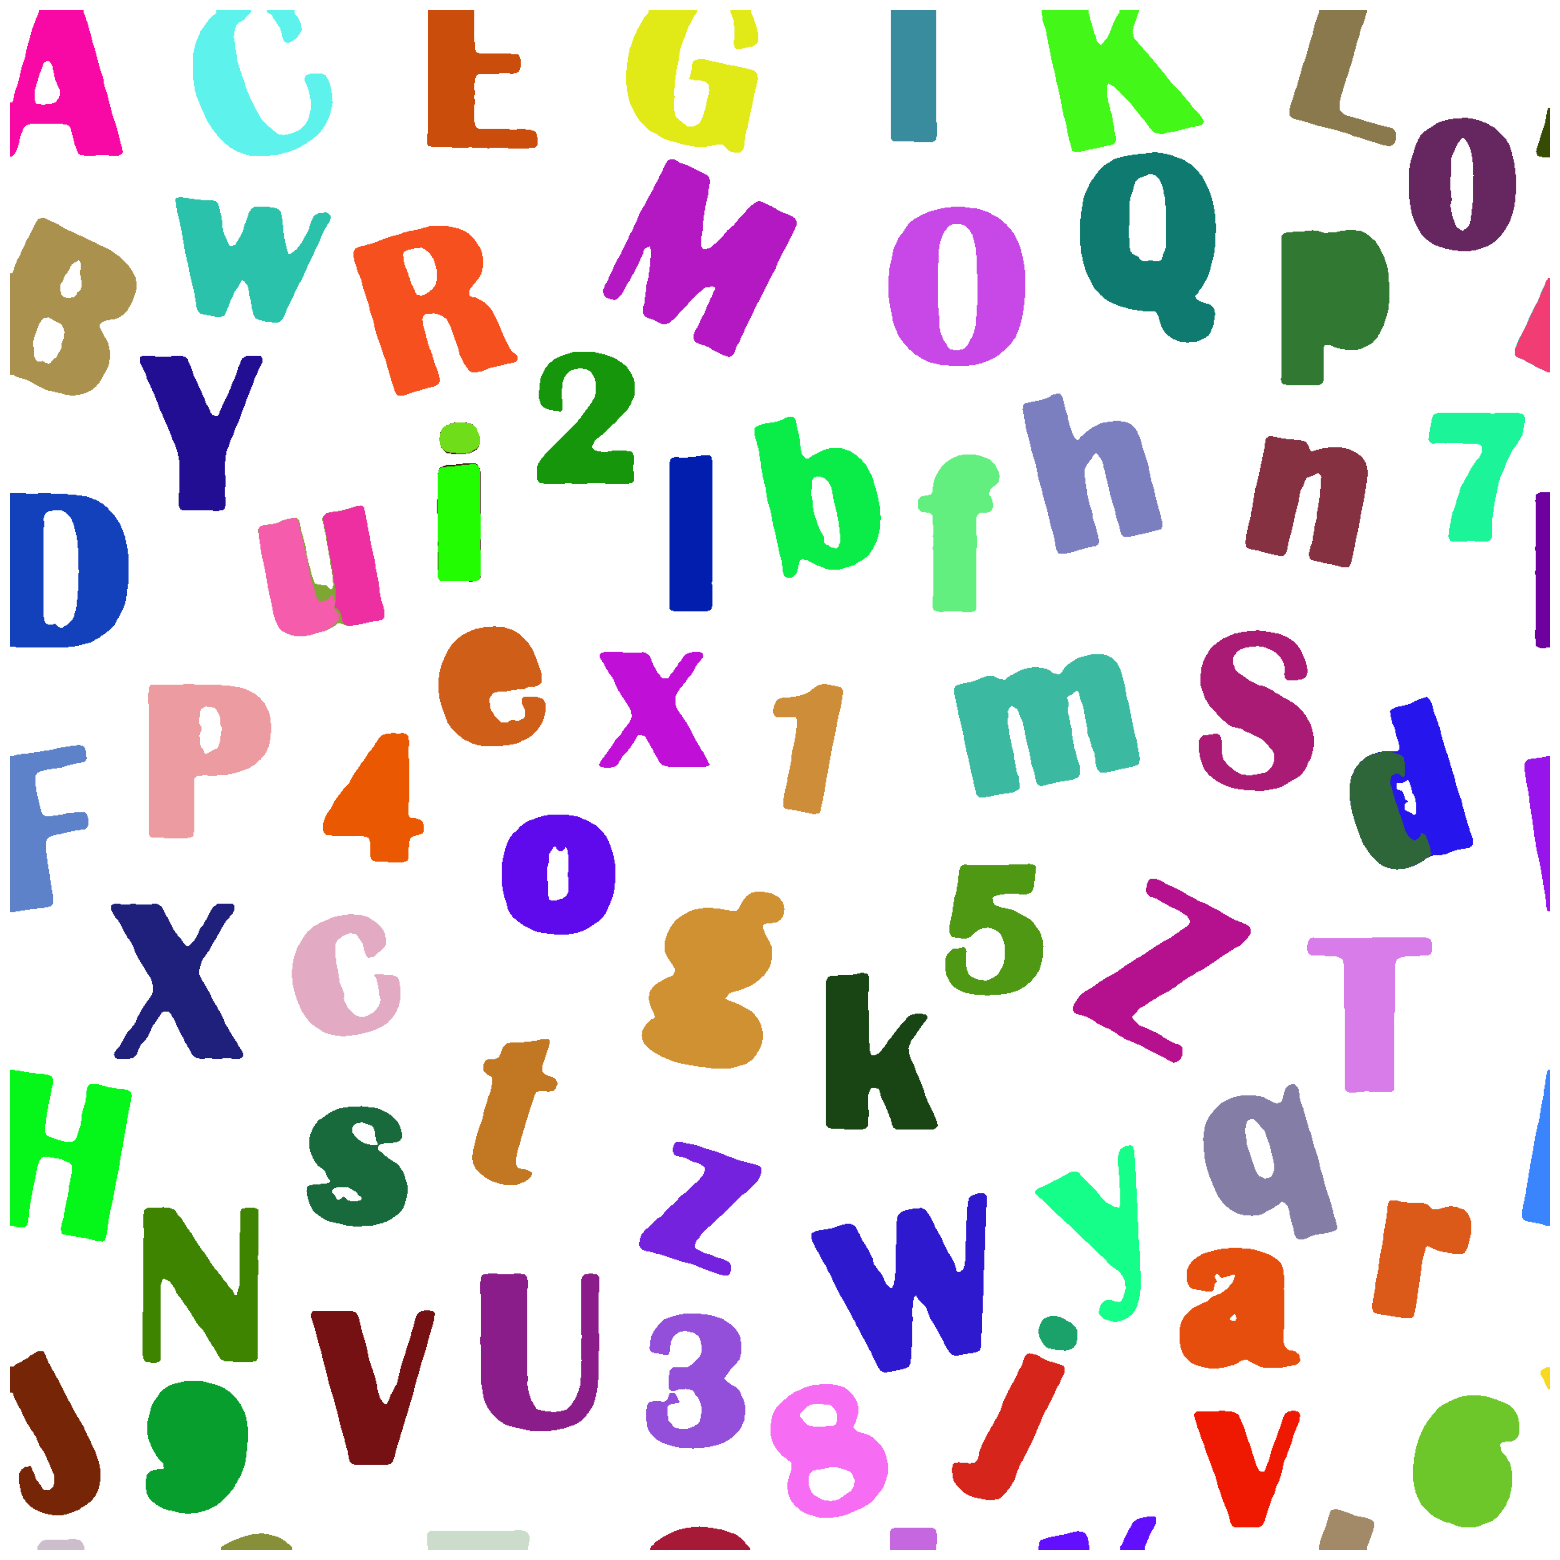

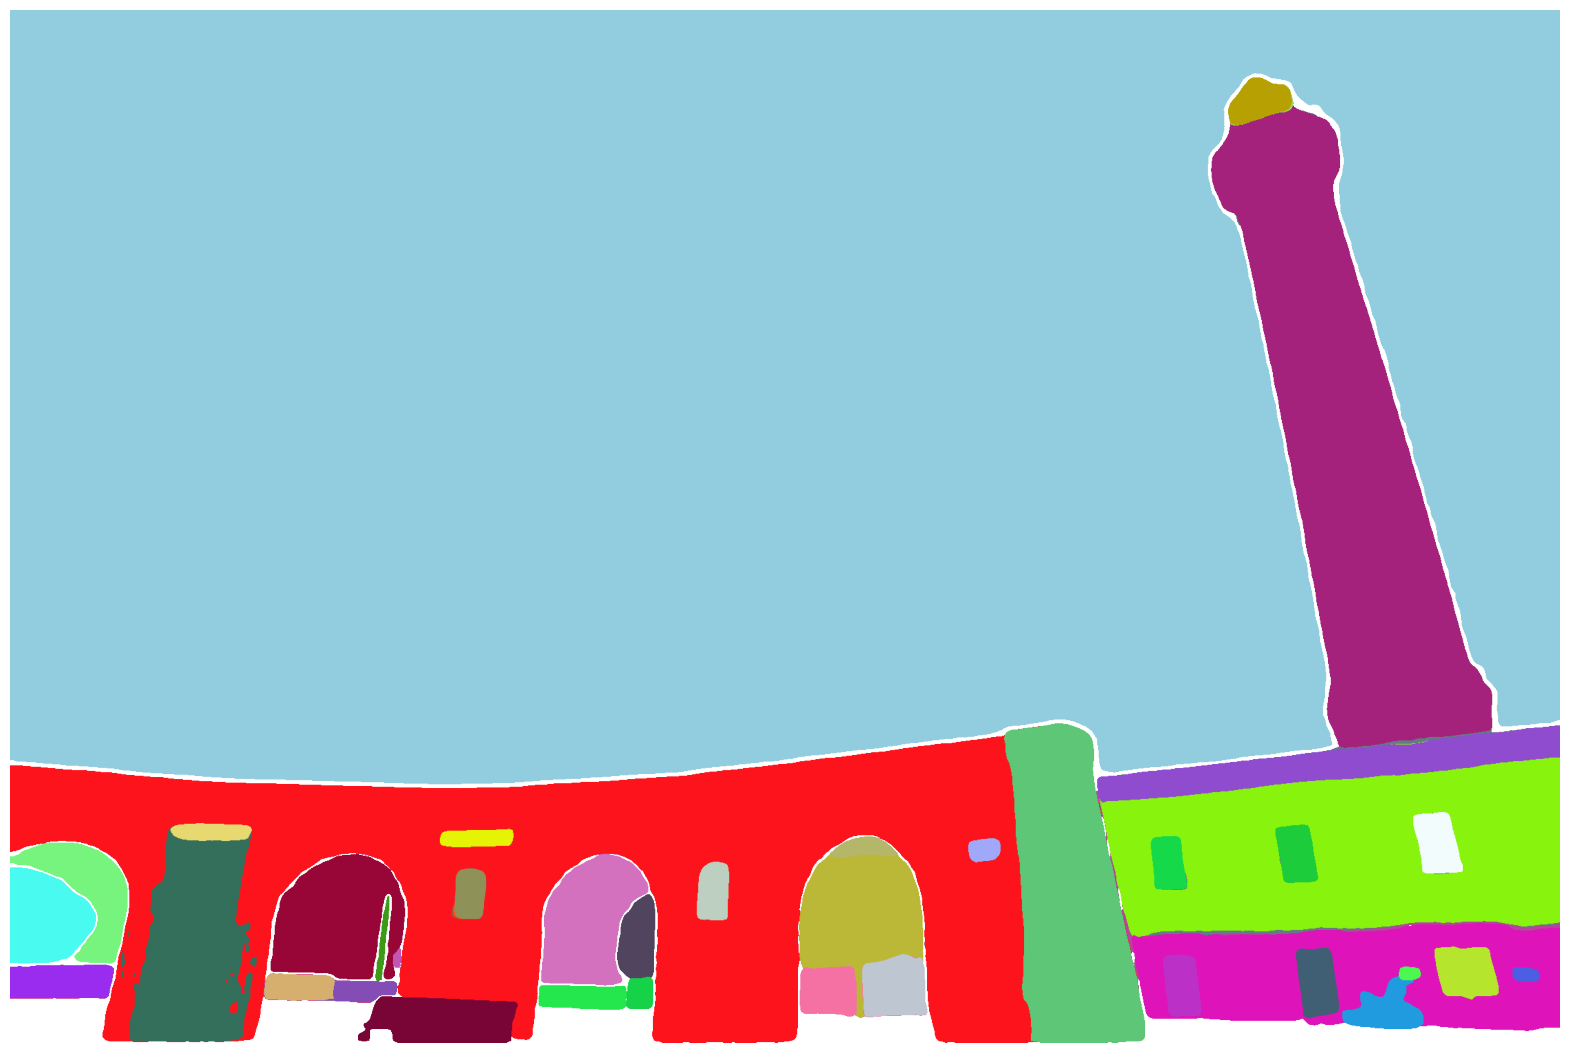

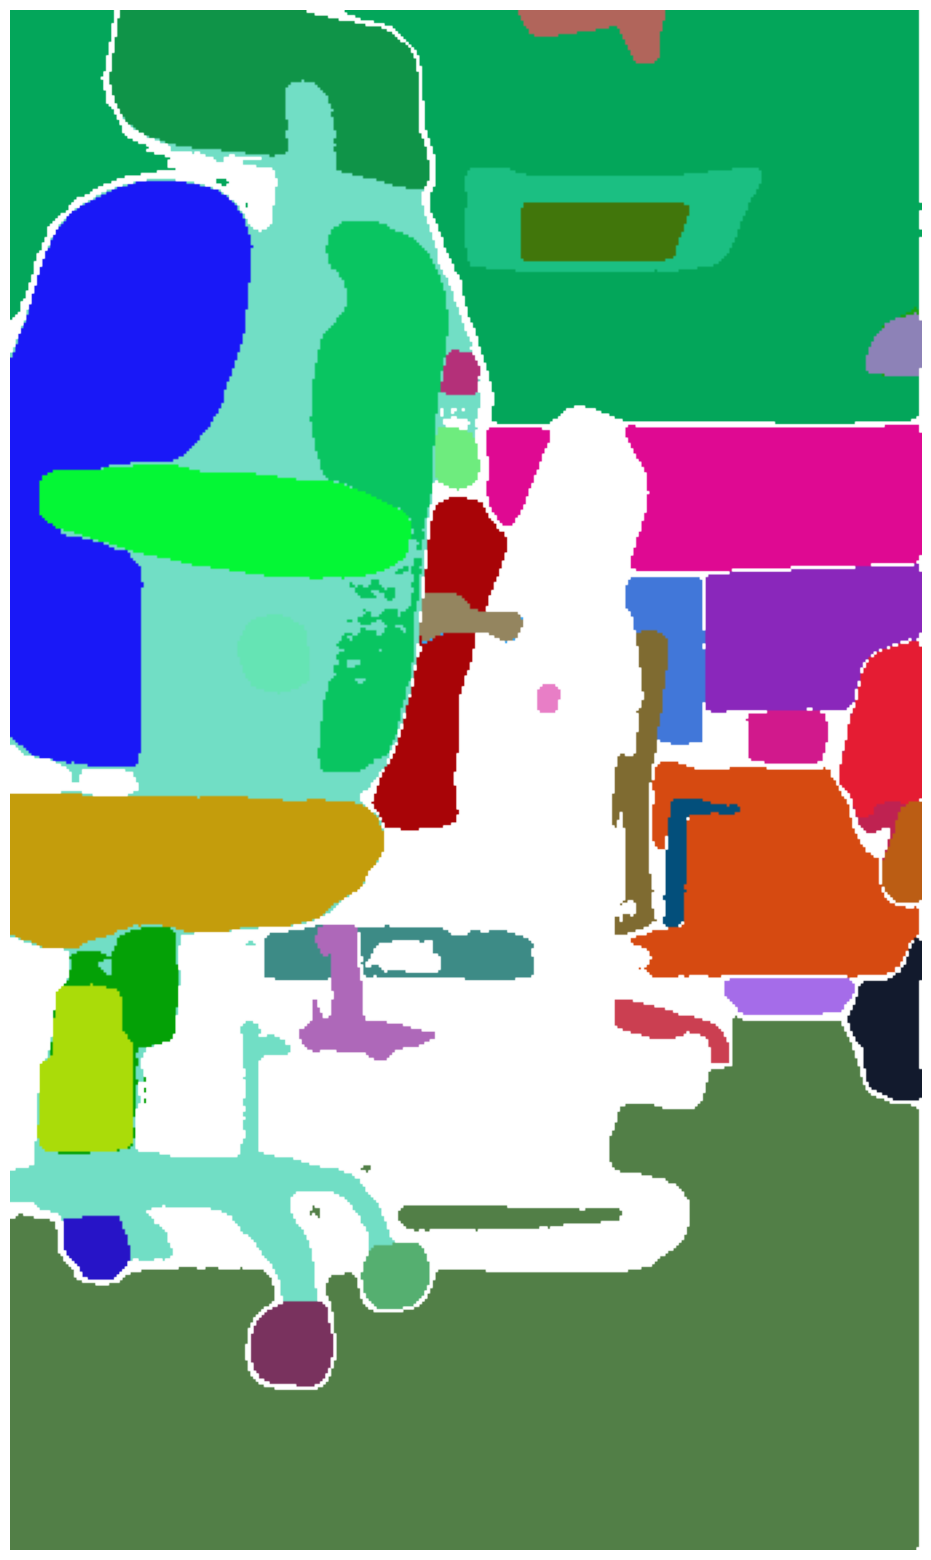

In [8]:
import argparse
import ast
import torch
from PIL import Image
import cv2
import os
import sys
from mobilesamv2.promt_mobilesamv2 import ObjectAwareModel
from mobilesamv2 import sam_model_registry, SamPredictor
from typing import Any, Dict, Generator,List
import matplotlib.pyplot as plt
import numpy as np
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--ObjectAwareModel_path", type=str, default='./PromptGuidedDecoder/ObjectAwareModel.pt', help="ObjectAwareModel path")
    parser.add_argument("--Prompt_guided_Mask_Decoder_path", type=str, default='./PromptGuidedDecoder/Prompt_guided_Mask_Decoder.pt', help="Prompt_guided_Mask_Decoder path")
    parser.add_argument("--encoder_path", type=str, default="./", help="select your own path")
    parser.add_argument("--img_path", type=str, default="./test_images/", help="path to image file")
    parser.add_argument("--imgsz", type=int, default=1024, help="image size")
    parser.add_argument("--iou",type=float,default=0.9,help="yolo iou")
    parser.add_argument("--conf", type=float, default=0.4, help="yolo object confidence threshold")
    parser.add_argument("--retina",type=bool,default=True,help="draw segmentation masks",)
    parser.add_argument("--output_dir", type=str, default="./", help="image save path")
    parser.add_argument("--encoder_type", type=str, default='tiny_vit', choices=['tiny_vit','sam_vit_h','mobile_sam','efficientvit_l2','efficientvit_l1','efficientvit_l0'], help="choose the model type")
    return parser.parse_args()
def create_model():
    Prompt_guided_path='./PromptGuidedDecoder/Prompt_guided_Mask_Decoder.pt'
    obj_model_path='./weight/ObjectAwareModel.pt'
    ObjAwareModel = ObjectAwareModel(obj_model_path)
    PromptGuidedDecoder=sam_model_registry['PromptGuidedDecoder'](Prompt_guided_path)
    mobilesamv2 = sam_model_registry['vit_h']()
    mobilesamv2.prompt_encoder=PromptGuidedDecoder['PromtEncoder']
    mobilesamv2.mask_decoder=PromptGuidedDecoder['MaskDecoder']
    return mobilesamv2,ObjAwareModel
    
def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((anns.shape[1], anns.shape[2], 4))
    img[:,:,3] = 0
    for ann in range(anns.shape[0]):
        m = anns[ann].bool()
        m=m.cpu().numpy()
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)

def batch_iterator(batch_size: int, *args) -> Generator[List[Any], None, None]:
    assert len(args) > 0 and all(
        len(a) == len(args[0]) for a in args
    ), "Batched iteration must have inputs of all the same size."
    n_batches = len(args[0]) // batch_size + int(len(args[0]) % batch_size != 0)
    for b in range(n_batches):
        yield [arg[b * batch_size : (b + 1) * batch_size] for arg in args]

encoder_path={'efficientvit_l2':'./weight/l2.pt',
            'tiny_vit':'./weight/mobile_sam.pt',
            'sam_vit_h':'./weight/sam_vit_h.pt',}

# import pdb;pdb.set_trace()
def main(model):
    output_dir="./"  
    mobilesamv2, ObjAwareModel=create_model()
    image_encoder=sam_model_registry[model](encoder_path[model])
    mobilesamv2.image_encoder=image_encoder
    device = "cuda" if torch.cuda.is_available() else "cpu"
    mobilesamv2.to(device=device)
    mobilesamv2.eval()
    predictor = SamPredictor(mobilesamv2)
    image_files= os.listdir("./test_images/")
    show_img_ = []
    for image_name in image_files:
        print(image_name)
        image = cv2.imread("./test_images/" + image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        obj_results = ObjAwareModel(image,device=device,retina_masks=True,imgsz=1024,conf=0.4,iou=0.9)
        predictor.set_image(image)
        input_boxes1 = obj_results[0].boxes.xyxy
        input_boxes = input_boxes1.cpu().numpy()
        input_boxes = predictor.transform.apply_boxes(input_boxes, predictor.original_size)
        input_boxes = torch.from_numpy(input_boxes).cuda()
        sam_mask=[]
        image_embedding=predictor.features
        image_embedding=torch.repeat_interleave(image_embedding, 320, dim=0)
        prompt_embedding=mobilesamv2.prompt_encoder.get_dense_pe()
        prompt_embedding=torch.repeat_interleave(prompt_embedding, 320, dim=0)
        for (boxes,) in batch_iterator(320, input_boxes):
            with torch.no_grad():
                image_embedding=image_embedding[0:boxes.shape[0],:,:,:]
                prompt_embedding=prompt_embedding[0:boxes.shape[0],:,:,:]
                sparse_embeddings, dense_embeddings = mobilesamv2.prompt_encoder(
                    points=None,
                    boxes=boxes,
                    masks=None,)
                low_res_masks, _ = mobilesamv2.mask_decoder(
                    image_embeddings=image_embedding,
                    image_pe=prompt_embedding,
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=False,
                    simple_type=True,
                )
                low_res_masks=predictor.model.postprocess_masks(low_res_masks, predictor.input_size, predictor.original_size)
                sam_mask_pre = (low_res_masks > mobilesamv2.mask_threshold)*1.0
                sam_mask.append(sam_mask_pre.squeeze(1))
        sam_mask=torch.cat(sam_mask)
        annotation = sam_mask
        areas = torch.sum(annotation, dim=(1, 2))
        sorted_indices = torch.argsort(areas, descending=True)
        show_img = annotation[sorted_indices]
        show_img_.append(show_img)
        plt.figure(figsize=(20,20))
        background=np.ones_like(image)*255
        plt.imshow(background)
        show_anns(show_img)
        plt.axis('off')
        # plt.show() 
        # plt.savefig("{}".format(output_dir+image_name), bbox_inches='tight', pad_inches = 0.0) 
    return show_img_

models = ['tiny_vit','sam_vit_h','mobile_sam','efficientvit_l2','efficientvit_l1','efficientvit_l0']
tiny_vit_img = main(models[0])
# sam_vit_img = main(models[1])

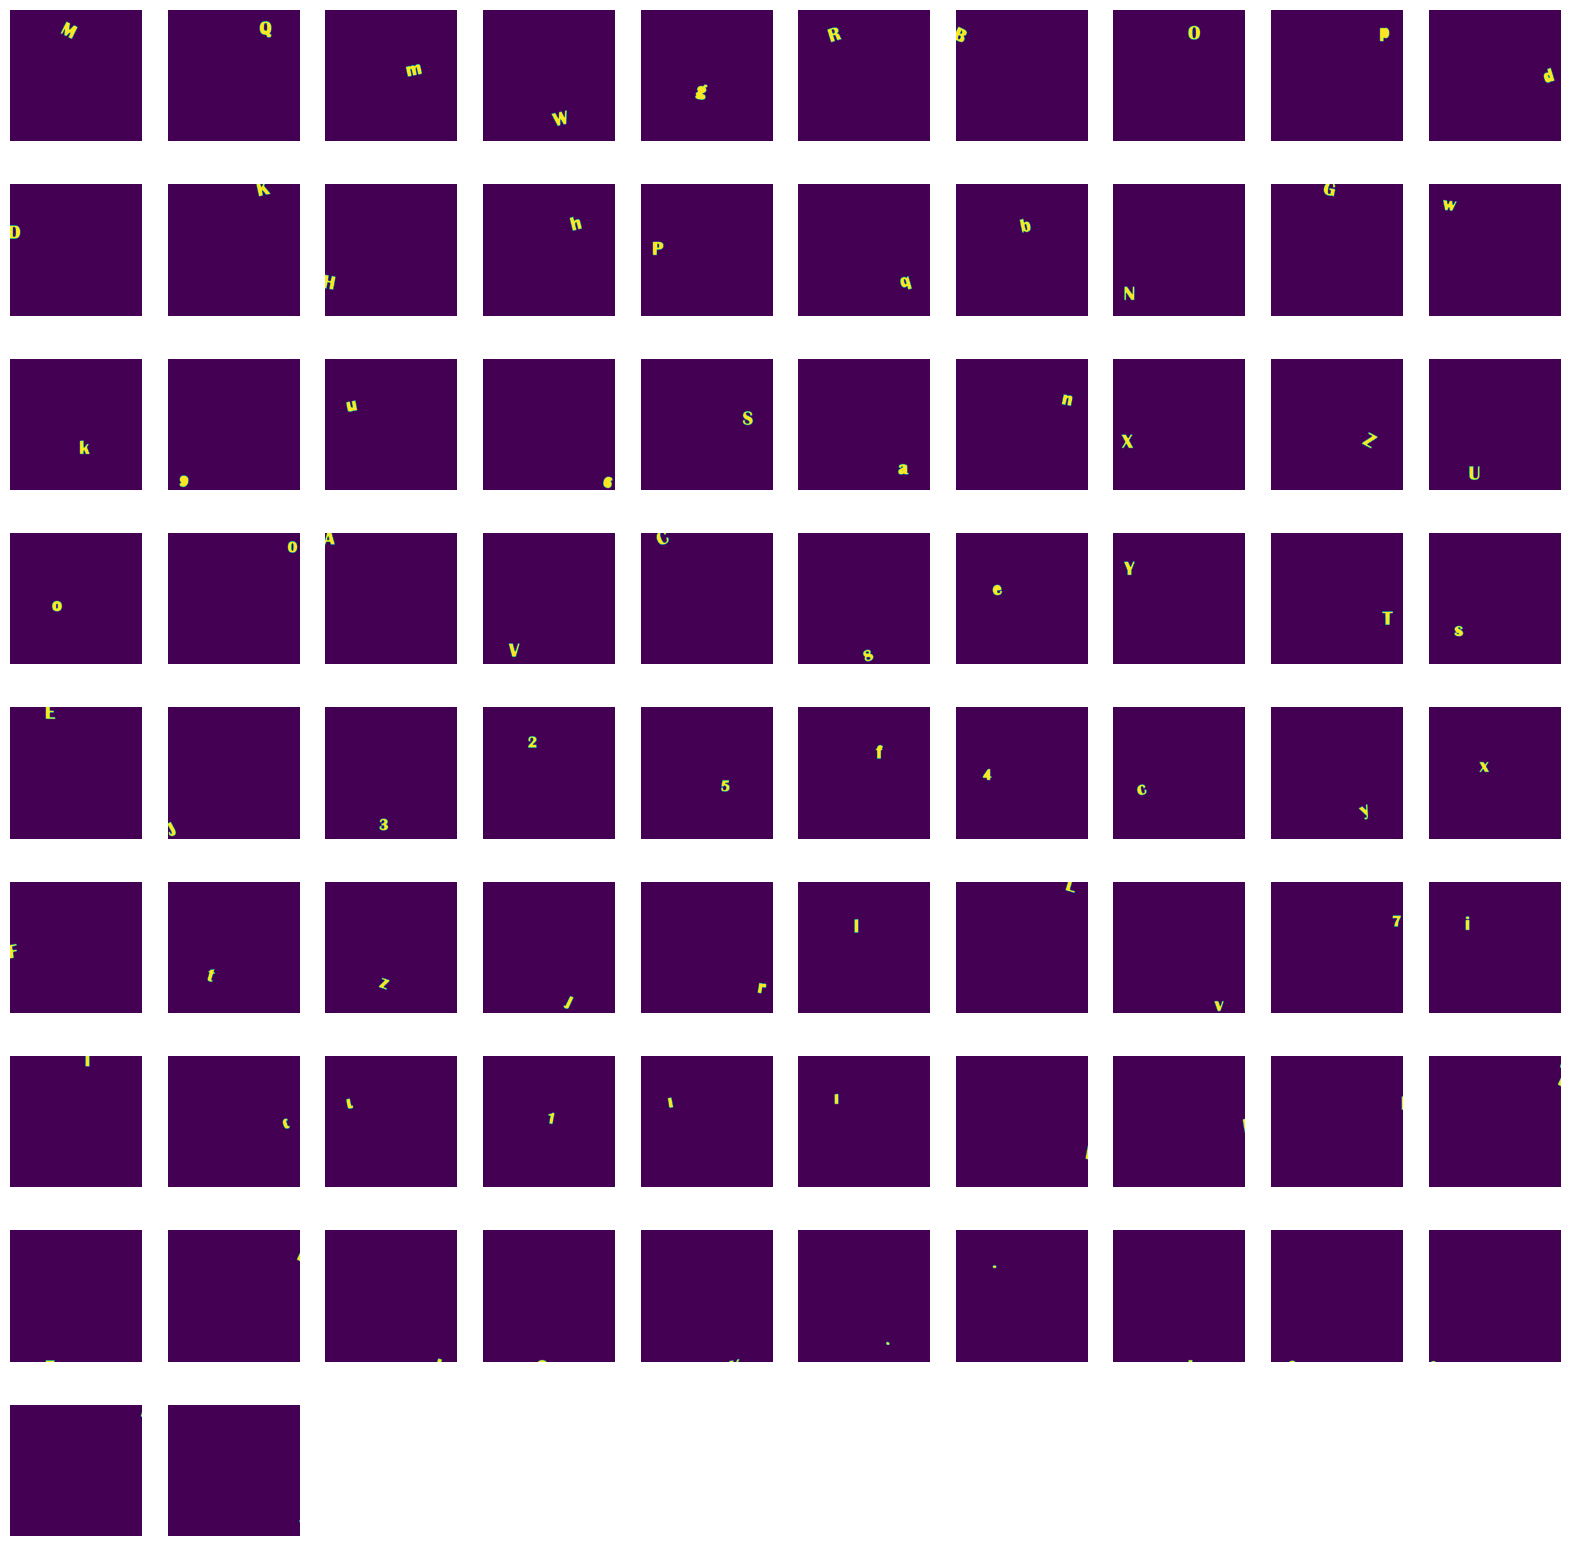

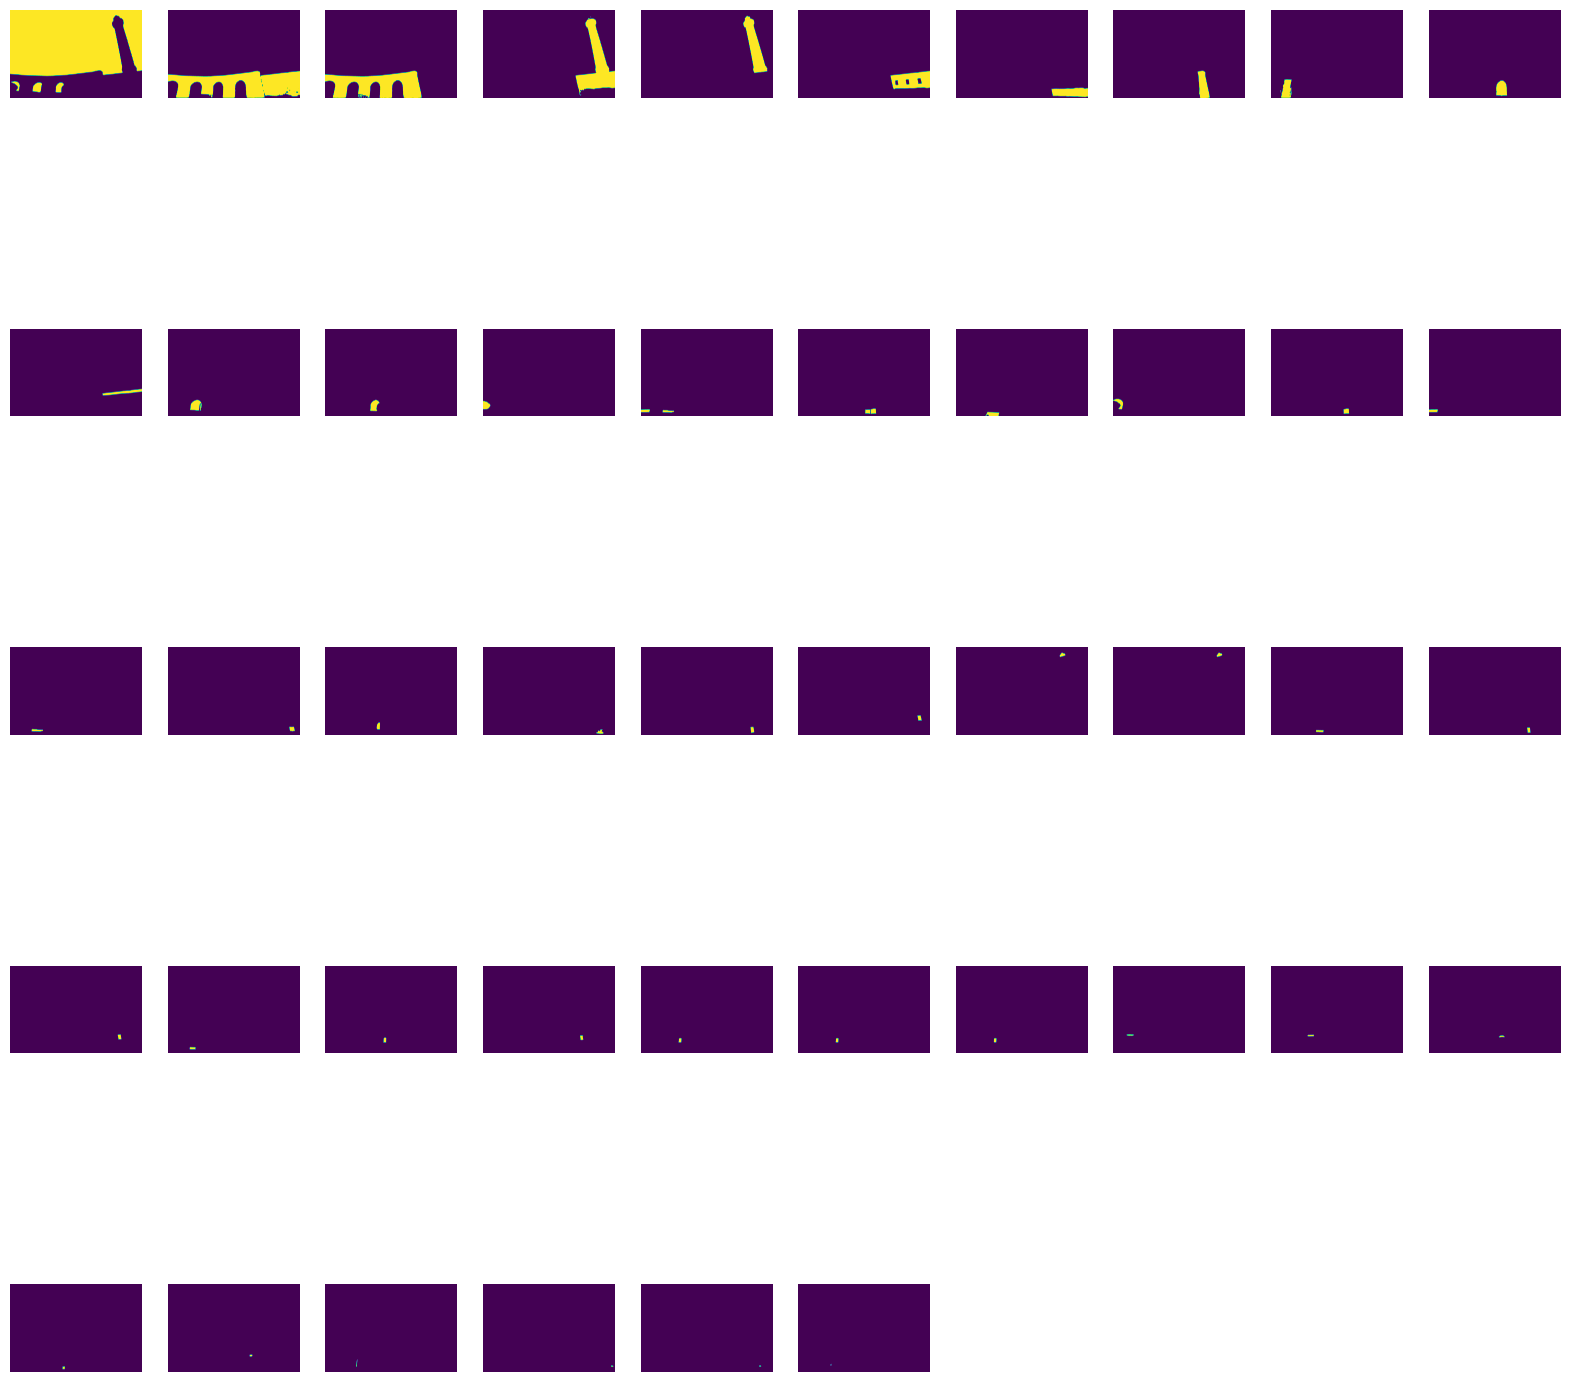

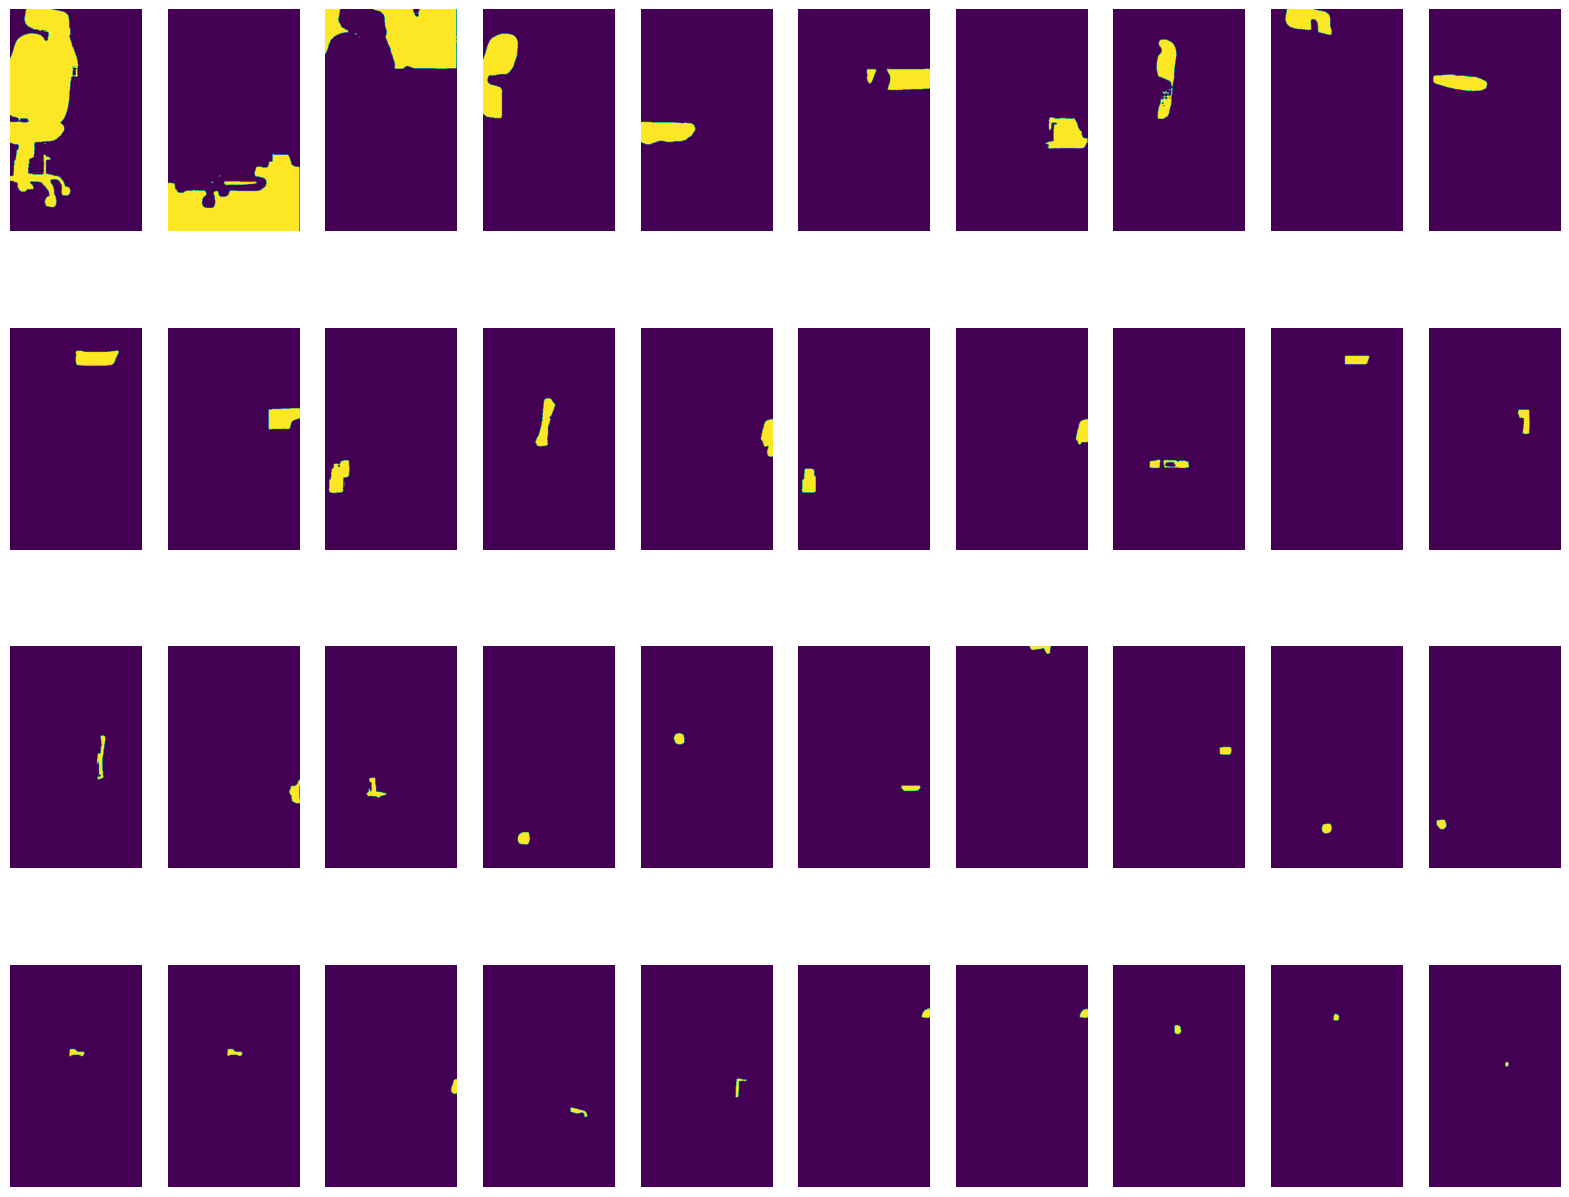

In [13]:
tvi1 = tiny_vit_img[0]
tvi2 = tiny_vit_img[1]
tvi3 = tiny_vit_img[2]
tvi1 = tvi1.cpu().numpy()
for i, annos in enumerate(tiny_vit_img):
    plt.figure(i, figsize=(20,20))
    annos = annos.cpu().numpy()
    for j in range(annos.shape[0]):
        plt.subplot(annos.shape[0]//10+1, 10, j+1)
        plt.imshow(annos[j])
        plt.axis('off')